# Velocity on a named selection
This notebook shows how to:
* Get the solution data from an Ansys Mechanical model (with shell / beam elements only)
* Get the velocity on a named selection (e.g. a shell element) for a harmonic analysis
* Get the data on a subset of nodes that are a given distance away from the mesh boundary


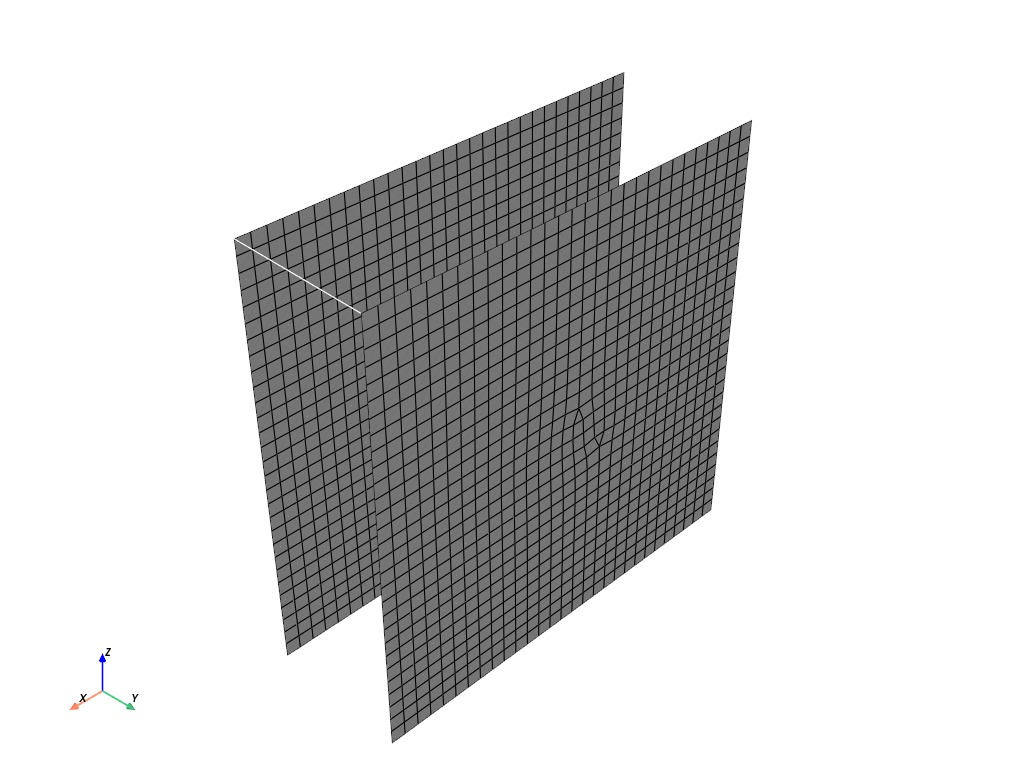

In [66]:
# import required modules
import os 
from ansys.dpf import core 
from ansys.dpf.core import operators as ops
import numpy as np 
import pyvista as pv 
import matplotlib.pyplot as plt 
import matplotlib.tri as tri

# input .rst file from solution 
path = "./project_Mech_Files/HarmonicResponse/file.rst"
file = os.path.abspath(path)

# get model / data from the file
ds = core.DataSources(file)
model = core.Model(file)
model.plot()

In [67]:
# this is the named selection to carry out the analysis on
# to run this analysis on multiple selection, the code should be adapted 
# to loop this processing over all named selections
NAMED_SELECTION = 'TOPFLOOR'

tf = model.metadata.time_freq_support

# get the set information 
freq_ids = list(range(1, tf.n_sets+1))
freq = tf.time_frequencies.data 

ns_operator = ops.scoping.on_named_selection()
ns_operator.inputs.named_selection_name.connect(NAMED_SELECTION)
ns_operator.inputs.data_sources.connect(model)

# get velocity on named selection
vel = ops.result.velocity(data_sources=model)
vel.inputs.mesh_scoping.connect(ns_operator.outputs.mesh_scoping)
vel.inputs.time_scoping.connect(freq_ids)
fields = vel.outputs.fields_container.get_data()

# get the mesh coordinates
mesh_region = model.metadata.meshed_region
scoping_op = ops.mesh.from_scoping(ns_operator.outputs.mesh_scoping, nodes_only=True)
scoping_op.inputs.mesh.connect(mesh_region)
mesh = scoping_op.outputs.mesh()
nodes = mesh.nodes # mesh nodes
coords = nodes.coordinates_field.data # surface coordinates

# finally, store the data in an array with dimensions (FREQUENCIES, NODES, VECTOR_DIMENSIONS)
data = np.zeros((len(freq), *coords.shape), dtype=np.complex128)

for i, f in enumerate(freq):   
    re = fields.get_field_by_time_id(i+1).data
    im = fields.get_imaginary_field(i+1).data
    data[i,:] = re + 1j*im

Now we can get and plot the Y component of velocity on the surface

Text(0, 0.5, 'm')

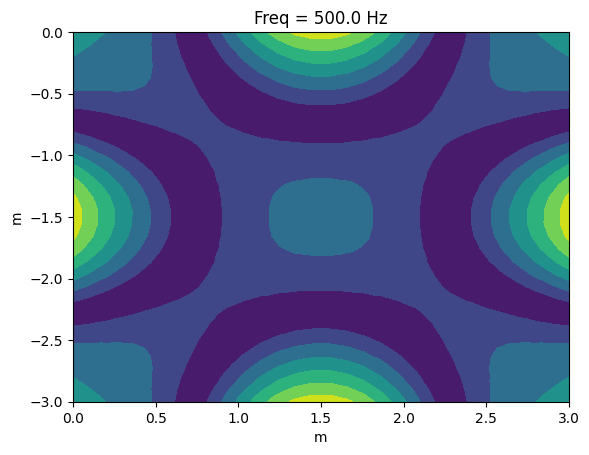

In [68]:
# now we get and plot the squared Y component of velocity on the surface
# possibilities: to use pyvista to compute the normals
X_COMP = 0
Y_COMP = 1 
Z_COMP = 2

freq_idx = 0 # which frequency / set index to use 

vel2 = np.abs(data[:,:,Y_COMP])
# for 2d plot
x,y,z = coords[:,0], coords[:,2], vel2[freq_idx, :]
triang = tri.Triangulation(x,y)
fig, ax = plt.subplots()

ax.set_title('Freq = {:.1f} Hz'.format(freq[freq_idx]))
ax.tricontourf(triang, z)
ax.set_xlabel('m')
ax.set_ylabel('m')


In the following section we use pyvista to find the inner surface of the mesh at a specified distance (`threshold`) from the full mesh boundary.

We also choose an evenly spaced distribution of points within that inner surface.

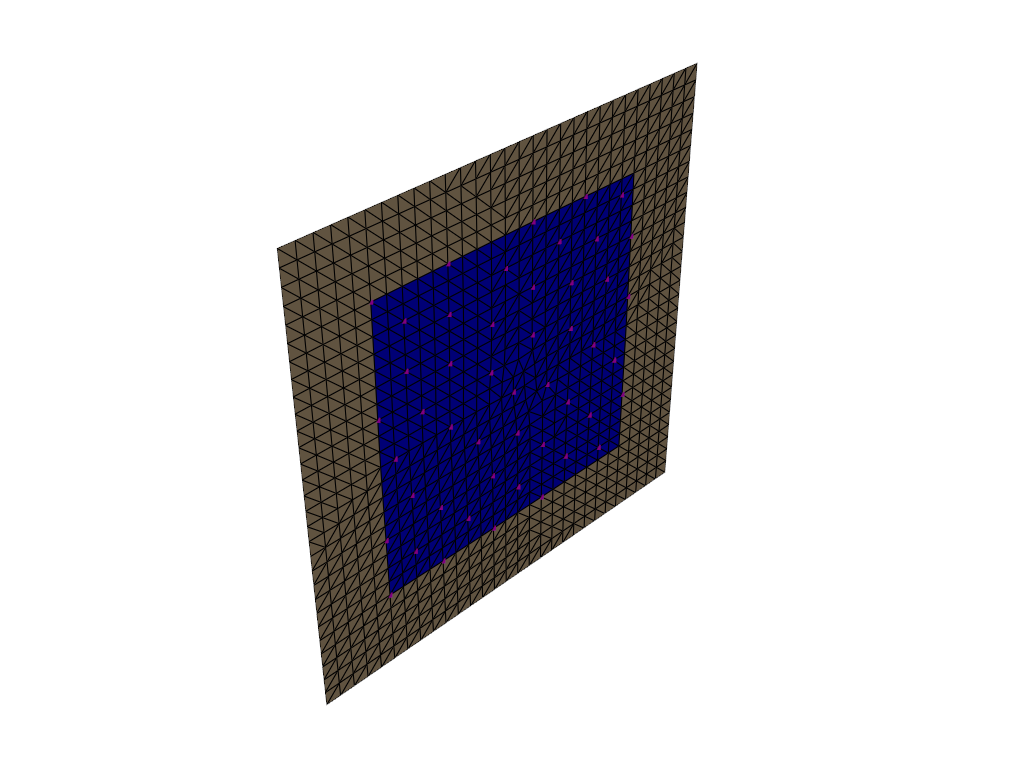

In [69]:
threshold = 0.5 # min distance from boundary in metres 

# (alternatively, it would be possible to use a percentage of the length of the mesh)

# convert coordinates to pyvista objects
cloud = pv.PolyData(coords)
surface = cloud.delaunay_2d()

# get the mesh boundary
boundary = surface.extract_feature_edges(boundary_edges=True,
                                         non_manifold_edges=False, 
                                         manifold_edges=False)

# calculate minimum distance from boundary using np.linalg.norm for each point on the mesh
dist = np.array([np.min(np.linalg.norm(point - boundary.points, axis=1)) for point in surface.points])
# now that we have dist= distance from the boundary, we can filter our data using [dist>threshold]

# selecting points at distance 'threshold' from boundary
sel_points = surface.points[dist >= threshold]
sel_surface = pv.PolyData(sel_points)
sel_surface_dela = sel_surface.delaunay_2d() # inner surface

# downsample the inner surface (instead of random index) this provides a uniform distribution of points
tolerance = 0.1 # set the tolerance at which the points are merged
# if absolute=True below, the tolerance will be in the coordinate unit
# if absolute=False, the tolerance is relative to the size of the surface (i.e. tolerance = 1 means you only get one point)
downsampled_inner_surface = sel_surface.clean(
    point_merging=True,
    merge_tol=tolerance,
    lines_to_points=False,
    polys_to_lines=False,
    strips_to_polys=False,
    inplace=False,
    absolute=False,
    progress_bar=False
)

idx_downsampled = np.array([any(np.all(downsampled_inner_surface.points == point, axis=1)) for point in cloud.points])


# plot the named selection surface and the inner surface at the given distance from boundary (in blue)
# randomly selected points in red
p = pv.Plotter()
p.add_mesh(surface, color='tan', show_edges=True) # full named selection surface
p.add_mesh(sel_surface_dela, color='blue', show_edges=True) # inner surface 
p.add_mesh(downsampled_inner_surface, color='purple', point_size=5) # sampled points

p.show()

Finally, we do some processing to the data within our target surface by filtering with `dist>threshold`

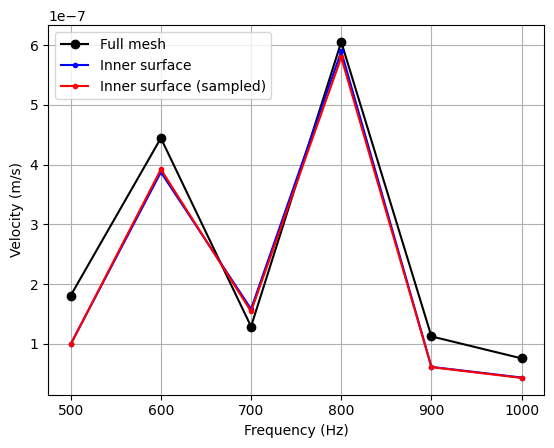

In [79]:

'''
In this example, looping over frequency and averaging the absolute velocity 
'''
# this is the velocity field for all points on the mesh
vel2_full = np.abs(data[:,:,Y_COMP])**2
velRMS_full = np.sqrt(vel2_full.mean(axis=1))

# this is the velocity field for all points on the inner surface
vel2_dist = np.abs(data[:,dist>threshold,Y_COMP])**2
velRMS_dist = np.sqrt(vel2_dist.mean(axis=1))

# this is the velocity field on the subset of points on the inner surface 
vel2_ds = np.abs(data[:,idx_downsampled,Y_COMP])**2
velRMS_ds = np.sqrt(vel2_ds.mean(axis=1))

fig, ax1 = plt.subplots()
# plot the 
ax1.plot(freq, velRMS_full, 'ko-', label='Full mesh')
ax1.plot(freq, velRMS_dist, 'b.-', label='Inner surface')
ax1.plot(freq, velRMS_ds, 'r.-', label='Inner surface (sampled)')
ax1.legend()

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Velocity (m/s)')
ax1.grid()

# export to csv 

np.savetxt("vdata.csv", np.column_stack((freq, velRMS_ds)), header='Exported Velocity Data', delimiter=",")
